In [22]:
import boto3
import pandas as pd
import pyarrow.parquet as pq
import io
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
import plotly.express as px

In [23]:
# Replace with your own credentials
aws_access_key_id = ''
aws_secret_access_key = ''

In [24]:
# Create a session using your credentials
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-east-1'  # e.g. 'us-east-1'
)

In [25]:
# Create an S3 client
s3 = session.client('s3')

In [26]:
# Define the bucket name and the file key
bucket_name = 'wage-etl-airflow'
prefix = 'clean_data/'


In [27]:
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
files = [obj['Key'] for obj in response.get('Contents', [])]


In [28]:
dfs = []
for file in files:
    if file.endswith('.parquet'):
        print(f'Reading {file}')
        
        # Get the file object from S3
        obj = s3.get_object(Bucket=bucket_name, Key=file)
        
        # Read the parquet file from the object body (content is in obj['Body'])
        file_data = obj['Body'].read()
        parquet_file = io.BytesIO(file_data)
        
        # Use pyarrow or pandas to read the parquet file into a DataFrame
        df = pd.read_parquet(parquet_file)
        
        # Append the DataFrame to the list
        dfs.append(df)

# Combine all files into one DataFrame
wage = pd.concat(dfs, ignore_index=True)



Reading clean_data/cleaned_wage_data/part-00000-tid-2928868939473729766-b45afc7e-86df-47f1-97bb-c1b9c3820a9b-191-1.c000.snappy.parquet
Reading clean_data/cleaned_wage_data/part-00002-tid-2928868939473729766-b45afc7e-86df-47f1-97bb-c1b9c3820a9b-195-1.c000.snappy.parquet
Reading clean_data/cleaned_wage_data/part-00003-tid-2928868939473729766-b45afc7e-86df-47f1-97bb-c1b9c3820a9b-197-1.c000.snappy.parquet
Reading clean_data/cleaned_wage_data/part-00004-tid-2928868939473729766-b45afc7e-86df-47f1-97bb-c1b9c3820a9b-198-1.c000.snappy.parquet
Reading clean_data/cleaned_wage_data/part-00005-tid-2928868939473729766-b45afc7e-86df-47f1-97bb-c1b9c3820a9b-196-1.c000.snappy.parquet
Reading clean_data/cleaned_wage_data/part-00006-tid-2928868939473729766-b45afc7e-86df-47f1-97bb-c1b9c3820a9b-192-1.c000.snappy.parquet
Reading clean_data/cleaned_wage_data/part-00007-tid-2928868939473729766-b45afc7e-86df-47f1-97bb-c1b9c3820a9b-194-1.c000.snappy.parquet


In [29]:
#highest wage industry in each province for year2023

wage = wage[wage['Overtime'] == 'Excluding overtime']
wage['max_wage'] = wage.groupby(['GEO','YEAR'])['Hourly Wage'].transform('max')   #this is max wage year and geo wise
wage[(wage['YEAR'] == 2023) & (wage['Hourly Wage'] == wage['max_wage'])]

,YEAR,Industry (NAICS),Hourly Wage,GEO,Overtime,max_wage
15780,2023,Information and cultural industries,35.03,Prince Edward Island,Excluding overtime,35.03
15857,2023,"Architectural, engineering and related services",39.04,Nova Scotia,Excluding overtime,39.04
15950,2023,Information and cultural industries,43.49,New Brunswick,Excluding overtime,43.49
16142,2023,Rail transportation,42.79,Quebec,Excluding overtime,42.79
16309,2023,Utilities,44.88,Ontario,Excluding overtime,44.88
16519,2023,"Architectural, engineering and related services",44.59,Manitoba,Excluding overtime,44.59
16629,2023,"Architectural, engineering and related services",44.40,Saskatchewan,Excluding overtime,44.40
16740,2023,"Electric power generation, transmission and di...",47.12,Alberta,Excluding overtime,47.12
16946,2023,Primary metal manufacturing,50.07,British Columbia,Excluding overtime,50.07
17026,2023,Construction,36.71,Yukon,Excluding overtime,36.71


In [30]:
#lowest wage industry in each province for year2023
 
wage['min_wage'] = wage.groupby(['GEO','YEAR'])['Hourly Wage'].transform('min')      #this is min wage year and geo wise
wage[(wage['YEAR'] == 2023) & (wage['Hourly Wage'] == wage['min_wage'])]

,YEAR,Industry (NAICS),Hourly Wage,GEO,Overtime,max_wage,min_wage
15776,2023,General merchandise retailers,18.11,Prince Edward Island,Excluding overtime,35.03,18.11
15867,2023,"Amusement, gambling and recreation industries",19.07,Nova Scotia,Excluding overtime,39.04,19.07
15942,2023,Grocery and convenience retailers,18.88,New Brunswick,Excluding overtime,43.49,18.88
16136,2023,Gasoline stations,18.53,Quebec,Excluding overtime,42.79,18.53
16411,2023,Full-service restaurants and limited-service e...,17.86,Ontario,Excluding overtime,44.88,17.86
16532,2023,Full-service restaurants and limited-service e...,16.86,Manitoba,Excluding overtime,44.59,16.86
16638,2023,Food services and drinking places,16.58,Saskatchewan,Excluding overtime,44.40,16.58
16818,2023,Food services and drinking places,17.89,Alberta,Excluding overtime,47.12,17.89
17011,2023,Accommodation and food services,19.54,British Columbia,Excluding overtime,50.07,19.54
17032,2023,Full-service restaurants and limited-service e...,18.20,Yukon,Excluding overtime,36.71,18.20


In [31]:
wage_province = wage[wage['GEO'] != 'Canada']
wage_province

,YEAR,Industry (NAICS),Hourly Wage,GEO,Overtime,max_wage,min_wage
557,2009,Industrial aggregate excluding unclassified bu...,19.22,Newfoundland and Labrador,Excluding overtime,29.48,10.93
558,2009,Goods producing industries,21.23,Newfoundland and Labrador,Excluding overtime,29.48,10.93
559,2009,Construction,21.24,Newfoundland and Labrador,Excluding overtime,29.48,10.93
560,2009,Specialty trade contractors,20.79,Newfoundland and Labrador,Excluding overtime,29.48,10.93
561,2009,Building equipment contractors,23.97,Newfoundland and Labrador,Excluding overtime,29.48,10.93
...,...,...,...,...,...,...,...
30873,2023,"Arts, entertainment and recreation",20.46,Newfoundland and Labrador,Excluding overtime,48.99,17.09
30874,2023,Other services (except public administration),25.45,Newfoundland and Labrador,Excluding overtime,48.99,17.09
30875,2023,Repair and maintenance,27.46,Newfoundland and Labrador,Excluding overtime,48.99,17.09
30876,2023,Personal care services,19.96,Newfoundland and Labrador,Excluding overtime,48.99,17.09


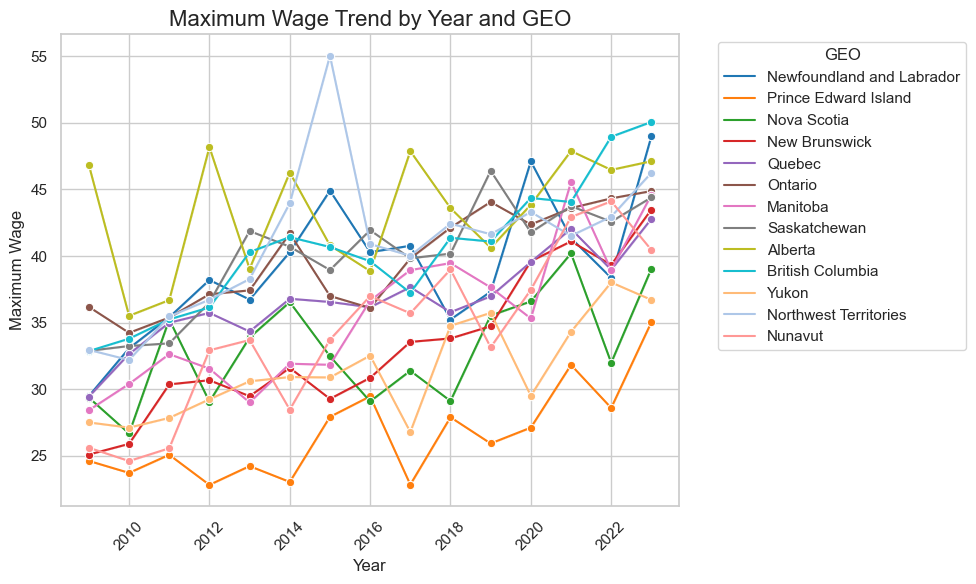

In [32]:
# Set the plot style
sns.set(style='whitegrid')

# Custom color palette for 13 lines
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
                  '#ffbb78', '#aec7e8', '#ff9896']

plt.figure(figsize=(10, 6))

sns.lineplot(data=wage_province, x='YEAR', y='max_wage', hue='GEO', marker='o',palette=custom_palette)

plt.title('Maximum Wage Trend by Year and GEO', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Maximum Wage', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='GEO', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [33]:
wage_province['max_wage_year'] = wage_province.groupby('YEAR')['Hourly Wage'].transform('max') #this is max_wage year wise
wage_province_max_year = wage_province[wage_province['Hourly Wage'] == wage_province['max_wage_year']]
wage_province_max_year = wage_province_max_year[['YEAR','Industry (NAICS)','GEO','max_wage_year']]
wage_province_max_year

C:\Users\mahar\AppData\Local\Temp\ipykernel_44452\3176909196.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,YEAR,Industry (NAICS),GEO,max_wage_year
1701,2009,Oil and gas extraction,Alberta,46.83
3176,2013,"Support activities for mining, and oil and gas...",Saskatchewan,41.88
5511,2014,Oil and gas extraction,Alberta,46.27
7843,2015,Wholesale trade,Northwest Territories,55.04
9329,2016,"Mining, quarrying, and oil and gas extraction",Saskatchewan,41.94
11499,2017,Oil and gas extraction,Alberta,47.88
13469,2018,"Mining, quarrying, and oil and gas extraction",Alberta,43.60
15271,2019,"Mining, quarrying, and oil and gas extraction",Saskatchewan,46.40
16946,2023,Primary metal manufacturing,British Columbia,50.07
17789,2010,Natural gas distribution,Alberta,35.51


In [34]:
import plotly.express as px

# Create a bar plot using Plotly with improved aesthetics
fig = px.bar(
    wage_province_max_year,
    x='YEAR',
    y='max_wage_year',
    title='Maximum Wage by Year, GEO, and Industry',
    color='GEO',
    text='max_wage_year',  # Show max wage inside the bars
    labels={'max_wage_year': 'Maximum Wage (CAD)', 'YEAR': 'Year'},
)

# Customize bar appearance and add borders
fig.update_traces(
    texttemplate='%{text:.2f}', 
    textposition='inside',
    marker=dict(line=dict(color='black', width=1.5)),  # Add borders to bars
    opacity=0.85  # Slightly transparent for visual effect
)

# Limit y-axis to reduce the impact of a very large bar
y_max = wage_province_max_year['max_wage_year'].quantile(0.95) * 1.2  # 95th percentile with buffer
fig.update_yaxes(range=[0, y_max], title='Maximum Wage (CAD)', titlefont=dict(size=16), tickfont=dict(size=14))

# Alternatively, uncomment the following line to use a logarithmic scale for the y-axis
# fig.update_yaxes(type="log", tickformat=".0f")  # Log scale for better readability with large value ranges

# Further layout customization
fig.update_layout(
    title_font=dict(size=24, family='Arial', color='black'),  # Adjust title font and color
    xaxis_title='Year',
    yaxis_title='Maximum Wage (CAD)',
    xaxis_tickangle=-45,  # Rotate x-axis labels for readability
    xaxis=dict(
        tickmode='linear',
        tickvals=wage_province_max_year['YEAR'].unique()  # Ensure all years are shown
    ),
    legend_title_text='GEO',
    legend=dict(font=dict(size=14)),
    margin=dict(l=50, r=50, t=70, b=50),
    hoverlabel=dict(bgcolor='white', font_size=14, font_family='Arial'),
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper background
)

# Add gridlines for y-axis
fig.update_yaxes(showgrid=True, gridcolor='gray', gridwidth=1)

# Show the plot
fig.show()


In [35]:
wage_province['min_wage_year'] = wage_province.groupby('YEAR')['Hourly Wage'].transform('min') #this is max_wage year wise
wage_province_min_year = wage_province[wage_province['Hourly Wage'] == wage_province['min_wage_year']]
wage_province_min_year = wage_province_min_year[['YEAR','Industry (NAICS)','GEO','min_wage_year']]
wage_province_min_year = wage_province_min_year.drop_duplicates()
wage_province_min_year

C:\Users\mahar\AppData\Local\Temp\ipykernel_44452\1906296432.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,YEAR,Industry (NAICS),GEO,min_wage_year
740,2009,Full-service restaurants and limited-service e...,Nova Scotia,10.50
2944,2010,Gasoline stations,New Brunswick,11.52
5825,2014,Full-service restaurants and limited-service e...,British Columbia,12.60
6591,2015,Food services and drinking places,Nova Scotia,12.62
9261,2016,Full-service restaurants and limited-service e...,Manitoba,13.06
11242,2017,Food services and drinking places,Manitoba,13.49
13266,2018,Full-service restaurants and limited-service e...,Manitoba,13.57
14384,2019,Full-service restaurants and limited-service e...,Newfoundland and Labrador,14.19
16638,2023,Food services and drinking places,Saskatchewan,16.58
18794,2011,Gasoline stations,Prince Edward Island,11.51


In [36]:
 wage_province_min_year =  wage_province_min_year.sort_values('GEO').drop_duplicates(subset=['min_wage_year'], keep='first')

In [37]:
# Create a bar plot using Plotly with improved aesthetics
fig = px.bar(
    wage_province_min_year,  # Use the filtered DataFrame for minimum wages
    x='YEAR',
    y='min_wage_year',
    color='GEO',
    title='Minimum Wage by Year, and GEO',
    text='min_wage_year',  # Show min wage inside the bars
    labels={'min_wage_year': 'Minimum Wage (CAD)', 'YEAR': 'Year'},
)

# Customize layout and appearance
fig.update_traces(
    texttemplate='%{text:.2f}', 
    textposition='inside',
    marker=dict(line=dict(color='black', width=1.5)),  # Add borders to bars
    opacity=0.85  # Slightly transparent for visual effect
)

# Customize layout further
fig.update_layout(
    title_font=dict(size=24, family='Arial', color='black'),  # Title font style
    xaxis_title='Year',
    yaxis_title='Minimum Wage (CAD)',
    xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
    xaxis=dict(
        tickmode='linear',  # Ensure all years are shown
        tickvals=wage_province_min_year['YEAR'].unique()  # Use unique years
    ),
    yaxis=dict(titlefont=dict(size=16), tickfont=dict(size=14)),  # Font size for axes
    legend_title_text='GEO',
    legend=dict(font=dict(size=14)),  # Font size for legend
    margin=dict(l=50, r=50, t=70, b=50),  # Adjust margins for better spacing
    hoverlabel=dict(bgcolor='white', font_size=14, font_family='Arial'),  # Customize hover labels
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper background
)

# Add gridlines for better readability
fig.update_yaxes(showgrid=True, gridcolor='gray', gridwidth=1)

# Show the plot
fig.show()